# Import Required Libraries

In [2]:
import os
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Dataset Configuration

Setup for image size, batch size, and dataset paths.

In [5]:
images_size = 100  # Image size 
batch_size = 64    # Batch size 
train_path = '../dataset\\raf-db-5class\\train'  # Training dataset path
test_path = '../dataset\\raf-db-5class\\test'    # Testing dataset path

# Data Augmentation

Augmentation for training (normalization, rotation, flip, etc.) and normalization for testing.

In [6]:
# Augmentasi data untuk training (normalisasi, kecerahan, flip horizontal, rotasi, geser, zoom, dll)
train_datagen = ImageDataGenerator(
    rescale=1./255, brightness_range=[0.9, 1.1], horizontal_flip=True, 
    rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
    shear_range=0.2, zoom_range=0.2, channel_shift_range=10.0, fill_mode='nearest'
)

# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(images_size, images_size), batch_size=batch_size, 
    seed=32, shuffle=True, class_mode='categorical'
)

# Augmentasi data untuk testing (normalisasi dan split validasi)
test_datagen = ImageDataGenerator(
    rescale=1./255, validation_split=0.5
)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    test_path, target_size=(images_size, images_size), batch_size=batch_size, 
    shuffle=False, class_mode='categorical'
)

Found 11268 images belonging to 5 classes.
Found 2834 images belonging to 5 classes.


### Classes used

In [4]:
# Cek struktur dataset
print(f"Train folder contains: {os.listdir(train_path)}")
print(f"Test folder contains: {os.listdir(test_path)}")

Train folder contains: ['angry', 'neutral', 'sad', 'surprised', 'happy']
Test folder contains: ['angry', 'neutral', 'sad', 'surprised', 'happy']


# Callbacks

Callback settings for early stopping, learning rate reduction, and learning rate scheduling.

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',  
    patience=5,         
    verbose=1,          
    factor=0.5,          
    min_lr=0.00001       
)

from tensorflow.keras import optimizers

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, 
    decay_steps=1000,            
    decay_rate=0.5,            
)

from keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

def learning_rate_schedule(epoch):
    initial_lr = 0.001
    drop_factor = 0.5
    epoch_drop = 10
    return initial_lr * (drop_factor ** (epoch // epoch_drop))

lr_callback = LearningRateScheduler(learning_rate_schedule)

optimizer = Adam()

# Custom CNN Model

A custom Convolutional Neural Network (CNN) model with multiple convolutional layers, batch normalization, max pooling, dropout, and regularization.

- **Conv2D Layers**: Multiple convolutional layers with varying filters and kernel sizes.
- **BatchNormalization**: Applied after each convolution layer for stable training.
- **MaxPooling2D**: Pooling layers to downsample feature maps.
- **Dropout**: Added after each layer to prevent overfitting.
- **Dense Layers**: Fully connected layers with ReLU activation.

In [ ]:
def CustomCNN():
    model= tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(images_size,images_size,3)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
        
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(5, activation='softmax'))
    return model

# Training the model

In [ ]:
modelCustom = CustomCNN()

modelCustom.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    '5kelasterbaek.keras',                  # Nama file untuk menyimpan model
    monitor='val_accuracy',           # Memantau akurasi validasi
    save_best_only=True,               # Hanya menyimpan model dengan performa terbaik
    mode='max',                        # Mode 'max' berarti model dengan nilai tertinggi yang akan disimpan
    verbose=1                          # Menampilkan status setiap kali model disimpan
)

history = modelCustom.fit(train_generator,
                          # steps_per_epoch=train_generator.samples // batch_size,
                          epochs=200,
                          validation_data=test_generator,
                          # validation_steps=test_generator.samples // batch_size, 
                          callbacks=[lr_callback,checkpoint]  # Use the lr_callback here
)


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733402185.137700      91 service.cc:145] XLA service 0x7b4fd800a920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733402185.137776      91 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/177 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.2227 - loss: 9.6221   

I0000 00:00:1733402204.227321      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/177 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step - accuracy: 0.3275 - loss: 9.0076

I0000 00:00:1733402241.097856      89 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_4', 64 bytes spill stores, 64 bytes spill loads



177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.3551 - loss: 8.5354
Epoch 1: val_accuracy improved from -inf to 0.41814, saving model to 5kelasterbaek.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 83s 322ms/step - accuracy: 0.3555 - loss: 8.5269 - val_accuracy: 0.4181 - val_loss: 4.8979 - learning_rate: 0.0010
Epoch 2/200
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5657 - loss: 3.3506
Epoch 2: val_accuracy improved from 0.41814 to 0.56457, saving model to 5kelasterbaek.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.5658 - loss: 3.3474 - val_accuracy: 0.5646 - val_loss: 2.4157 - learning_rate: 0.0010
Epoch 3/200
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6266 - loss: 1.9200
Epoch 3: val_accuracy improved from 0.56457 to 0.62562, saving model to 5kelasterbaek.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.6267 - loss: 1.9190 - val_accuracy: 0.6256 - val_loss: 1.7343 - learning_rate: 0.0010
Epoch 4/200
177/177 ━━━━━━━━━━━━━━━━━━━━ 0

# Evaluating the Model

In [7]:
modelCustom = load_model("../model/5kelas.keras")
test_loss, test_acc = modelCustom.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}, test loss: {test_loss:.2f}")

c:\Users\Sanju\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8900 - loss: 0.5429
Test accuracy: 0.88, test loss: 0.57


# Model Confusion Matrix & Evaluation Metrics

45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step


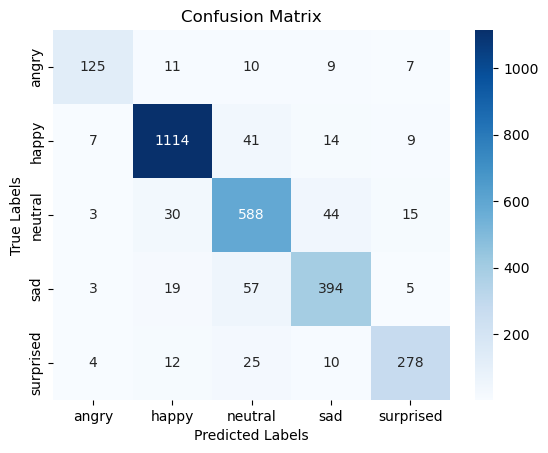

              precision    recall  f1-score   support

       angry       0.88      0.77      0.82       162
       happy       0.94      0.94      0.94      1185
     neutral       0.82      0.86      0.84       680
         sad       0.84      0.82      0.83       478
   surprised       0.89      0.84      0.86       329

    accuracy                           0.88      2834
   macro avg       0.87      0.85      0.86      2834
weighted avg       0.88      0.88      0.88      2834



In [8]:
class_names = ['angry', 'happy', 'neutral', 'sad', 'surprised']
# Mendapatkan prediksi dari generator validasi
y_true = test_generator.classes  # Label asli
y_pred = modelCustom.predict(test_generator)  # Probabilitas prediksi
y_pred_classes = np.argmax(y_pred, axis=1)  # Kelas prediksi

# Menampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)